# Camera Calibration
To correctly transform the turbine as it is placed into the Google Street View image, the camera matrix needs to be derived, which calculates the neccessary transformations required to to convert between the camera coordinate system and the global coordinate system

In [511]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

To establish a coherent framework, we begin by defining the global coordinate system. In this context, a right-handed coordinate system is employed, wherein positive changes in the x-axis represent longitudinal shifts, positive changes in the y-axis denote latitudinal shifts, and positive changes in the z-direction signify an increase in elevation. 
<br> ![title](../jupyter-book/images/coord_sys.png)

## Intrinsic parameters
$K = \begin{bmatrix}
\alpha_x & \gamma & u_0 & 0\\
0 & \alpha_y & v_0 & 0\\
0 & 0 & 1 & 0
\end{bmatrix}$

The $K$ matrix comprises five intrinsic parameters specific to the camera model being used. These parameters encompass essential factors such as the focal length, image sensor format, and camera principal point.

Two of these parameters, $\alpha_x = f \cdot m_x$ and $\alpha_y = f \cdot m_y$, express the focal length in terms of pixels. Here, $m_x$ and $m_y$ represent the inverses of the width and height of a pixel on the projection plane, while $f$ denotes the focal length measured in terms of distance. The skew coefficient between the x and y axes, denoted as $\gamma$, is typically assumed to be 0. The parameters $u_0$ and $v_0$ represent the principal point, ideally located at the center of the image.


In [512]:
f = 0.02 # focal length
shape = [250, 250] # shape of image in pixels
fov = [90, 90]

def intrinsic_parameters(f, shape, fov):
    """
    INPUT:
        f : float
            focal length
        shape : array_like
            shape of image [pixels]
        fov : array_like
            horizontal and vertical field-of-view
    OUTPUT:
        K : ndarray (3, 3)
                camera calibration matrix
    """
    hfov = np.deg2rad(fov[0]) # horizontal field of view
    vfov = np.deg2rad(fov[1]) # vertical field of view
    m_x = 1/((np.tan(hfov/2)*f)/(shape[1]/2))
    m_y = 1/((np.tan(vfov/2)*f)/(shape[0]/2))
    a_x = f * m_x; a_y = f * m_y

    K = np.array([[a_x, 0, shape[1]/2], 
                [0, a_y, shape[0]/2], 
                [0, 0, 1]])
    
    return K

K = intrinsic_parameters(f, shape, fov)

print(K)

[[125.   0. 125.]
 [  0. 125. 125.]
 [  0.   0.   1.]]


## Rotation Matrix
A rotation matrix serves as a transformation matrix employed to execute rotations in space. It facilitates the determination of the necessary rotations for converting between the real-world coordinate system and the camera coordinates by utilizing Euler angles. For instance, following the convention below, the matrix plays a crucial role in this process.

https://en.wikipedia.org/wiki/Rotation_matrix

In [513]:
yaw = np.deg2rad(0) # direction (Z)
pitch = np.deg2rad(0) # tilt (Y)
roll = np.deg2rad(0) # roll (X)
theta = np.array([roll, pitch, yaw]) 

def rotation_matrix(theta):
    """
    INPUT:
        theta : array_like (3, 1)
            Euler angles [rad]
    OUTPUT:
        R : ndarray (3, 3)
            rotation matrix
    """
    R_z = np.array([[np.cos(theta[2]),-np.sin(theta[2]),0],
                    [np.sin(theta[2]), np.cos(theta[2]),0],
                    [0,0,1]])
    R_y = np.array([[np.cos(theta[1]),0,np.sin(theta[1])],
                    [0,1,0],
                    [-np.sin(theta[1]),0,np.cos(theta[1])]])
    R_x = np.array([[1,0,0],
                    [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0,np.sin(theta[0]),np.cos(theta[0])]])
    
    R = R_x @ R_y @ R_z
    return R

R = rotation_matrix(theta)
print (R)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


https://en.wikipedia.org/wiki/3D_projection#Perspective_projection

Normalized camera matrix, $C_N = R (I | -ñ)$

In [514]:
n = np.array([0, 0, 0]) # 3D translation of camera origin and world origin

def extrinsic_parameters(R, n):
    """
    INPUT:
        R : array_like (3, 3)
            rotation matrix
        n : array_like
            camera origin
    OUTPUT:
        C_N : ndarray (3, 4)
            normalized camera matrix 
    """
    C_N = R @ np.column_stack((np.identity(3),-n)) # normalized camera matrix 
    return C_N

C_N = extrinsic_parameters(R, n)

def camera_matrix(K, C_N):
    P = K @ C_N
    return P

P = camera_matrix(K, C_N)


Let's test the functions by defining a point in 3D space.

In [515]:
point_coordinate = [0, 0, 1]
def image_plane(P, point_coordinate):

    point_coordinate = np.append(point_coordinate, 1)
    res = P @ point_coordinate
    u, v = (res/res[2])[:2]
    return u, v

u, v = image_plane(P, point_coordinate)

print(f"U: {u:.1f} px\nV: {v:.1f}")

U: 125.0 px
V: 125.0


In [516]:
# INPUTS
f = 1 # focal length
shape = [250, 250] # shape of image in pixels
fov = [90, 90]
K = intrinsic_parameters(f, shape, fov)
theta = np.array([np.deg2rad(-20), np.deg2rad(180), np.deg2rad(0)])
R = rotation_matrix(theta)
camera_origin = np.array([0, 0, 5]) # 3D translation of camera origin and world origin
C_N = extrinsic_parameters(R, camera_origin)
P = camera_matrix(K, C_N)
point_coordinate = np.array([0, 4, 12])
u, v = image_plane(P, point_coordinate)

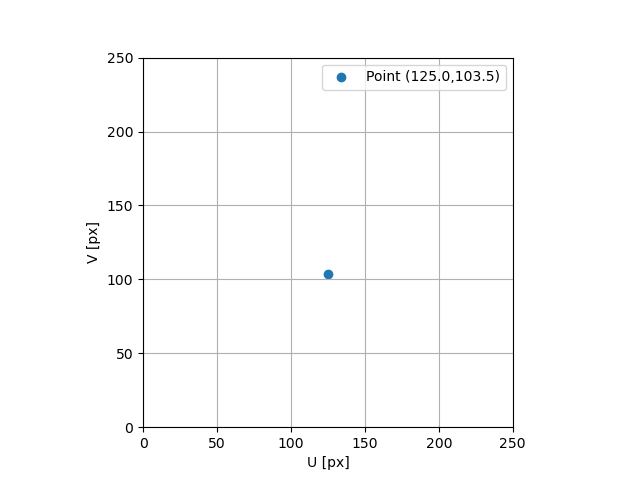

In [517]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(u, v, label = f"Point ({u:.1f},{v:.1f})")
ax.set(xlim = [0, shape[0]], 
       ylim = [0, shape[1]],
       xlabel = "U [px]",
       ylabel = "V [px]",
       aspect = "equal")
ax.grid()
ax.legend()
plt.show()

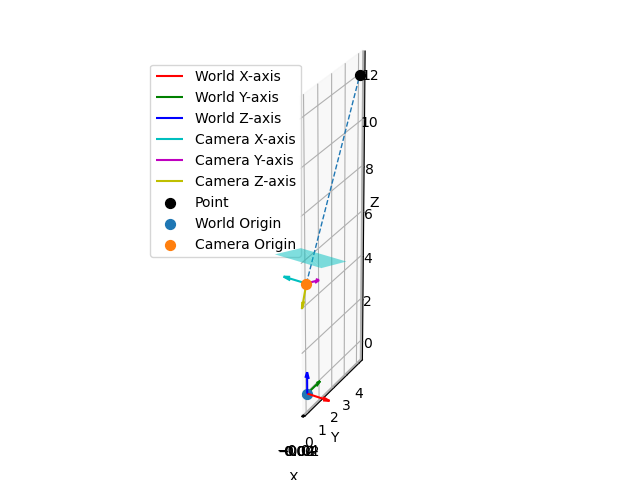

In [518]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the origin for world coordinates and unit vectors along the world coordinates
world_origin = [0, 0, 0]
world_x_vector = [1, 0, 0]
world_y_vector = [0, 1, 0]
world_z_vector = [0, 0, 1]

# Define the origin for camera coordinates and unit vectors along the camera coordinates
camera_x_vector = R @ world_x_vector
camera_y_vector = R @ world_y_vector 
camera_z_vector = R @ world_z_vector

# Plot the world coordinate system with labels
ax.quiver(*world_origin, *world_x_vector, color='r', label='World X-axis')
ax.quiver(*world_origin, *world_y_vector, color='g', label='World Y-axis')
ax.quiver(*world_origin, *world_z_vector, color='b', label='World Z-axis')

# Plot the camera coordinate system with labels
ax.quiver(*camera_origin, *camera_x_vector, color='c', label='Camera X-axis')
ax.quiver(*camera_origin, *camera_y_vector, color='m', label='Camera Y-axis')
ax.quiver(*camera_origin, *camera_z_vector, color='y', label='Camera Z-axis')

# Plot the 3D point with a label
ax.scatter(*point_coordinate, c='k', s=50, label='Point')
ax.scatter(*world_origin, s=50, label = "World Origin")
ax.scatter(*camera_origin, s=50, label = "Camera Origin")

#### INPUTS #####
f = -1
vfov = np.deg2rad(90)
hfov = np.deg2rad(90)

vl = 2*np.tan(vfov/2)*f # vertical length
hl = 2*np.tan(hfov/2)*f # horizontal length
zz = f *np.ones([2, 2]) # offset in z
xx, yy = np.meshgrid(np.linspace(-hl/2, hl/2, 2), np.linspace(-vl/2, vl/2, 2))
coord = np.einsum('ij,kj->ki', R, np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) + camera_origin
# ax.scatter(*coord.T)
vertices = [coord[[0, 1, 3]], coord[[0, 2, 3]]]
surface = Poly3DCollection(vertices, alpha=0.5)
surface.set_facecolor('c')
ax.add_collection3d(surface)

ax.plot(*np.array([camera_origin, point_coordinate]).T, linestyle = "dashed", linewidth = 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')
ax.legend()
plt.show()


Current errors:
- Pitch direction is reversed for 2D camera
- Roll direction is reversed for 2D camera